# 中国保险业过去五年基础数据分析

---

- 报告题目：中国保险业过去五年基础数据分析
- 学员昵称：stenphen
- 课程期数：第一期

© 本文著作权归作者所有，并授权实验楼独家使用，未经实验楼许可，不得转载使用。

---

## 项目作业介绍

“保险”是近两年来人们茶余饭后的热门话题，我本次的项目作业将从公开途径抓取中国保险业过去5年的基础数据，管中窥豹看一看这个行业及保险产品当前的状况，过去的发展及未来的驱势。

## 项目作业目录


- [保险数据采集](#保险数据采集)
- [数据清洗和预处理](#数据清洗和预处理)
- [数据分析阶段](#数据分析阶段)
- [项目作业总结](#项目作业总结)

### 保险数据采集

本次作业的数据是通过[和讯保险页面](http://insurance.money.hexun.com/bfsj/industryData.aspx?tp=%c8%ab%b9%fa&rank=0)采集自2013年1月至2018年9月的保险行业基础数据，主要是保险总保费，各险种保费，和总赔付支出，各险种赔付支出的数据。

In [1]:
# 通过网络爬虫爬取相关数据
import requests
from bs4 import BeautifulSoup

# 先定义一个获取页面数据的函数


def get_URL_data(base_url, date):  # 函数传参是网页页面，供爬取时分析，同时还需要传入页面的日期，因为相关页面是通过日期的不同来区别的
    r = requests.get(base_url)
    content = r.content
    soup = BeautifulSoup(content, 'lxml')
    month_data = []  # 定义个空 list，用来存储抓到的数据
    month_data.append(date)  # 传入的日期需要先存入 list 中作为 DataFrame 的 DatetimeIndex
    if not soup('i'):  # 如果网页中没有有效数据，则该月数据设为全零
        for k in range(12):
            month_data.append(0)
    else:  # 有效数据都是以 i 标签显示，获取标签内容并转换乘 float 型以后存入 list 中
        for j in range(12):
            month_data.append(float(soup('i')[j].text))
    return month_data  # 最后返回存了抓取数据的 list


# 设置 base url，和讯保险相关页面是通过 base url 和不同的日期组合来显示不同月份的保险基础数据的
base_url = 'http://insurance.money.hexun.com/bfsj/industryData.aspx?tp=%c8%ab%b9%fa&rank=&dt='
total_data = []  # 定义空 list，用来存储每个月通过上面函数获取的一组组月数据

for i in range(3, 9):  # 由于2018年只有9个月的数据，所以需要对抓取数据月份对应的年份进行判断
    for j in range(1, 13):
        if i == 8 and j == 10:  # 如果日期到了2018年10月，则结束数据抓取
            break
        elif j < 10:  # 网页的月份都是2位数，所以给出的日期中月份小于10的需要前面加个0
            date = '201{}-0{}-01'.format(i, j)
        else:                              # 月份大于10的由于已经是2位数就不用再加0了
            date = '201{}-{}-01'.format(i, j)
        total_data.append(get_URL_data(base_url+date, date)
                          )  # 通过上面定义的函数获取每月数据，再存入总数据表中

### 数据清洗和预处理

通过上面的数据爬取我们获取基本的数据数组以后，我们需要对数据进行基本的预处理，其中包括了生成 DataFrame，查看数据缺失及错误状况，添加缺失并修改错误数据。

In [2]:
import pandas as pd
import numpy as np
a = np.vstack(total_data)  # 将初始数组生成 DataFrame
columns_name = ['date', '原保险保费总收入', '财产险收入', '人身险总收入', '寿险收入', '健康险收入',
                '人身意外保险收入', '原保险赔付总支出', '财产险支出', '人身险总支出', '寿险支出', '健康险支出', '人身意外保险支出']
df = pd.DataFrame(data=a, columns=columns_name)

df.date = pd.to_datetime(df.date)  # 将传入的日期数据转变成 datatime
df.set_index('date', inplace=True)  # 将日期数据转成 DatatimeIndex

df1 = df.loc[:, :].astype(float)  # 确保每个表项都是 float 型

由于数据都是线性的，所以我们可以通过画图来看数据采集是否连续完整，有无错误。

In [3]:
# 本段内容是为了解决画图无法显示中文字体的问题，如果可以显示中文则无需执行本段内容
import matplotlib
# 指定默认字体 需要先将提交作业压缩包里面的 SimHei.ttf 文件放入 ~\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf 中
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
# 解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

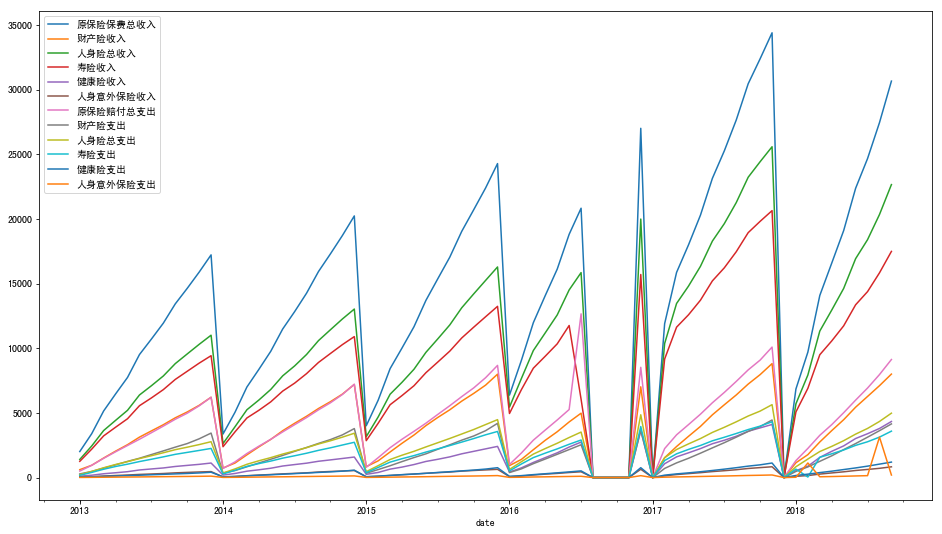

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
df1.plot(figsize=(16, 9))  # 对初始的 DataFrame 进行画图

根据图示，我们可以看到2016年后段，17年1月份，12月份数据缺失，此外，16年7月， 18年2月和8月线条都有突变，预示数据大概率有误。这里数据的矫正只能手动输入，矫正数据源自[保险监督管理委员会官网](http://hubei.circ.gov.cn/web/site0/tab5257/)。 

官网数据网页没有规律，且网页内表格不同年份的格式不一致，所以并未直接作为数据源进行采样。

In [5]:
df2 = df1.replace(0, np.nan)  # 先将0值全部替换成 NAN 值，以便后期检查是否还有未补缺数据

# 获取缺失的基本月份数据
data1608 = [22958.9373, 5635.0848, 17323.8524, 13721.4564, 3098.2305,
            504.1655, 6901.1431, 2937.1279, 3964.0152, 3242.7249, 605.3101, 115.9803]
data1609 = [25168.2615, 6370.5827, 18797.6788, 14783.8733, 3430.4069,
            583.3985, 7750.6999, 3321.5870, 4429.1129, 3610.5333, 687.1908, 131.3888]
data1610 = [27010.3752, 7018.3821, 19991.9932, 15703.9707, 3647.7410,
            640.2814, 8526.1670, 3670.1245, 4856.0425, 3946.5561, 763.4167, 146.0697]
data1611 = [28864.8711, 7773.0544, 21091.8167, 16556.6817, 3841.7960,
            693.3390, 9450.0194, 4131.1226, 5318.8968, 4287.5209, 870.7195, 160.6564]
data1701 = [8553.4033, 973.8127, 7579.5907, 6861.5894, 641.1138,
            76.8875, 1277.2914, 419.6850, 857.6063, 729.5261, 109.4866, 18.5937]
data1712 = [36581.0074, 9834.6579, 26746.3495, 21455.5650, 4389.4604,
            901.3241, 11180.7933, 5087.4496, 6093.3437, 4574.8907, 1294.7670, 223.6859]
data1612 = [30959.1009, 8724.4981, 22234.6028, 17442.2167, 4042.4968,
            749.8893, 10512.8900, 4726.1839, 5786.7061, 4602.9462, 1000.7522, 183.0077]

# 将缺失月份输入dataframe中
df2.loc['2016-08-01'] = pd.Series(data1608, index=df2.columns)
df2.loc['2016-09-01'] = pd.Series(data1609, index=df2.columns)
df2.loc['2016-10-01'] = pd.Series(data1610, index=df2.columns)
df2.loc['2016-11-01'] = pd.Series(data1611, index=df2.columns)
df2.loc['2017-01-01'] = pd.Series(data1701, index=df2.columns)
df2.loc['2017-12-01'] = pd.Series(data1712, index=df2.columns)
df2.loc['2016-12-01'] = pd.Series(data1612, index=df2.columns)

# 对数据错误表项，根据官网校验后修正
df2.loc['2016-07-01']['原保险赔付总支出'], df2.loc['2016-07-01']['寿险收入'] = df2.loc['2016-07-01']['寿险收入'], df2.loc['2016-07-01']['原保险赔付总支出']
df2.loc['2018-02-01'][-1], df2.loc['2018-02-01'][-3] = df2.loc['2018-02-01'][-3], df2.loc['2018-02-01'][-1]
df2.loc['2018-08-01'][-1] = df2.loc['2018-08-01'][-4] - \
    df2.loc['2018-08-01'][-3] - df2.loc['2018-08-01'][-2]

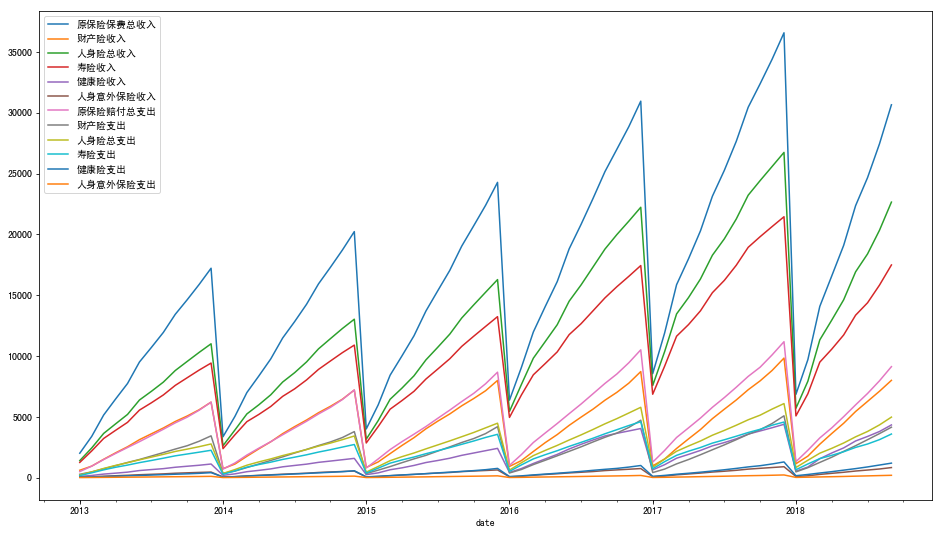

In [6]:
# 再次画图查看数据是否连续线性
df2.plot(figsize=(16, 9))

In [7]:
# 检验是否还有缺失数据项
df2.isnull().sum()

原保险保费总收入    0
财产险收入       0
人身险总收入      0
寿险收入        0
健康险收入       0
人身意外保险收入    0
原保险赔付总支出    0
财产险支出       0
人身险总支出      0
寿险支出        0
健康险支出       0
人身意外保险支出    0
dtype: int64

查看过官网以后，我们还发现，每个月的数据其实都是当年自一月份以来数据之和，而不是单个月数据，这意味着我们对除一月份以外的数据，都需要减去该月之前一个月的数据，以算出真正该月产生的保险数据。

In [8]:
df_month = df2.copy()

i = len(df_month)
while i > 0:
    i -= 1  # 从表最后一行往前修正数据
    if (df_month.index[i]).to_pydatetime().month == 1:  # 如果当月月份是一月份，则数据不需要修改
        continue
    else:  # 非一月份的当月数据需要减去前面一个月的数据以获取当月值
        df_month.loc[df_month.index[i]
                     ] -= df_month.loc[df_month.index[i] - pd.DateOffset(months=1)]

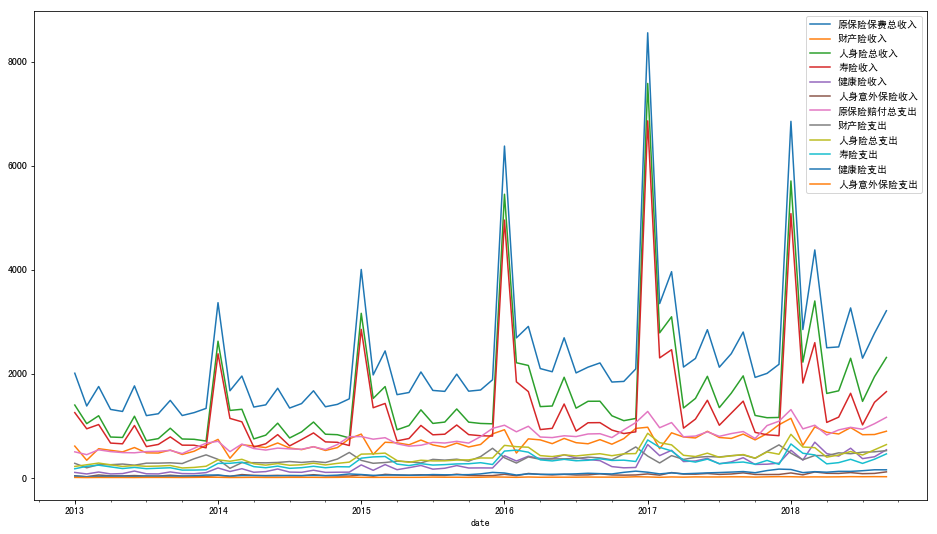

In [9]:
# 获取最终的月数据，画图检验
df_month.plot(figsize=(16, 9))

In [10]:
# 本段代码是直接加载作业压缩包中的 csv 文件时候才需要，如果执行过网络爬取代码不需要执行这些代码
'''
df = pd.read_csv('insurance_data.csv')
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace = True)
df_month = df.loc[:,:].astype(float)
'''

"\ndf = pd.read_csv('insurance_data.csv')\ndf.date = pd.to_datetime(df.date)\ndf.set_index('date',inplace = True)\ndf_month = df.loc[:,:].astype(float)\n"

In [11]:
# 根据月数据生成季度数据和年度数据
df_year = df_month.resample('Y').sum()
df_quarter = df_month.resample('Q').sum()

至此，数据清洗和预处理阶段完成，我们可以进入数据分析阶段。

### 数据分析阶段

数据分析阶段，我们将分成当前数据状态分析，过去统计数据分析和未来状态预测三个方面来进行。

#### 当前保险业状态分析

我们先看看2018年至今各项数据的总和。

In [12]:
# 显示2018年至今年度数据总和,该数据其实只有1--9月份之和，但是按年统计，所以时间戳显示成年底状态
df_year['2018']

,原保险保费总收入,财产险收入,人身险总收入,寿险收入,健康险收入,人身意外保险收入,原保险赔付总支出,财产险支出,人身险总支出,寿险支出,健康险支出,人身意外保险支出
date,,,,,,,,,,,,
2018-12-31,30661.794614,8003.403521,22658.391093,17490.754321,4337.006117,830.630655,9129.419104,4149.55674,4979.862364,3589.267172,1195.269131,195.326061


我们可以看到当前不到一年的时间保费总收入已超过3万亿元，这是个巨大的体量。作为对比，当前中国股市总市值也不过40万亿不到，也就是说中国的保险市场，一年保费收入就有近十分一股市总市值的价值了。而且各项对应的收入/赔付之间差距巨大，就算再加上各种人工成本，也不难想象行业本身状况应该是比较良好的。

我们再根据2018年保险业收入和支出的饼图来对当前保险业各险种占比状态进行下分析。

([<matplotlib.patches.Wedge at 0x199c299f160>,
 [Text(0.156613,1.08879,'财产险赔付'),
  Text(-0.640382,-0.894377,'寿险赔付'),
  Text(0.940216,-0.570959,'健康险赔付'),
  Text(1.09752,-0.073881,'人身意外险赔付')],
 [Text(0.0854255,0.593888,'45.45%\n(4149.56 亿元)'),
  Text(-0.349299,-0.487842,'39.32%\n(3589.27 亿元)'),
  Text(0.512845,-0.311432,'13.09%\n(1195.27 亿元)'),
  Text(0.598645,-0.0402987,'2.14%\n(195.33 亿元)')])

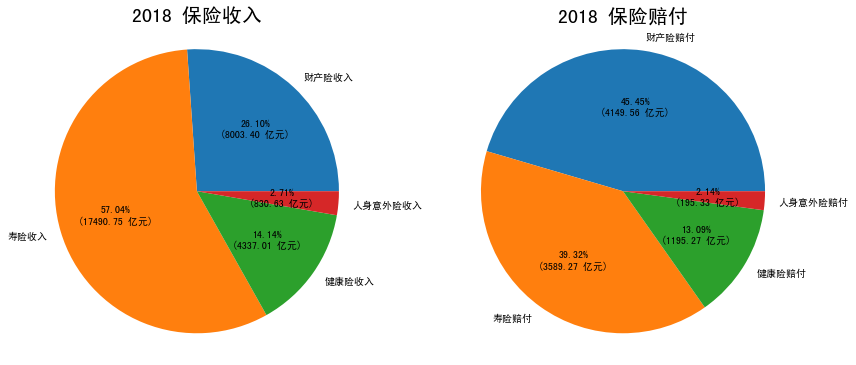

In [13]:
# 2017年保费收入和赔付的饼图
# 先定义一个简单函数，使得饼图中不但可以显示百分比，还能显示具体数字显示


def pct_number(pct, data):
    number = float(pct/100.*np.sum(data))
    return "{:.2f}%\n({:.2f} 亿元)".format(pct, number)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))  # 画两个饼图，一个收入，一个赔付
axes[0].axis('equal')  # 两个圆都是正圆
axes[1].axis('equal')

labels0 = ['财产险收入', '寿险收入', '健康险收入', '人身意外险收入']  # 定义饼图不同部分标签
labels1 = ['财产险赔付', '寿险赔付', '健康险赔付', '人身意外险赔付']

axes[0].set_title("2018 保险收入", fontsize=20)  # 定义饼图 title
axes[1].set_title("2018 保险赔付", fontsize=20)

# 截取2018年各单项险种数据进行展示
axes[0].pie(df_year.iloc[-1, [1, 3, 4, 5]], labels=labels0,
            autopct=lambda pct: pct_number(pct, df_year.iloc[-1, [1, 3, 4, 5]]))
axes[1].pie(df_year.iloc[-1, [7, 9, 10, 11]], labels=labels1,
            autopct=lambda pct: pct_number(pct, df_year.iloc[-1, [7, 9, 10, 11]]))

通过2018至今年第三季度饼图中各保险占比和费用数据展示，我们可以清楚的看到：

1.在保险收入的部分，寿险占到了近六成份额，是保险公司绝对的营收大头。然而在支出部分，寿险却不是支出最多的，同时收入和支出的差额是各种险种中最大的。

为什么会造成这样的数据差距呢？其实懂点商业保险的都知道单纯的人寿保险同等保额对应的保费普遍并不会比健康险更贵，所以这里的寿险是个泛指，我个人认为里面很大比例应该是所谓的年金险占了大头。由于年金险也是在被保险人身故时结束保险责任的一种人身保险，所以在划类时也被划分到了寿险类是可以理解的。

简单的说年金险就是你年轻的时候存钱，年老了用，妥妥的“卯吃寅粮”，所以他的缴费和赔付模式和其他险种不同，需要短期缴大笔的钱，此外，年金险一般还会同时卖一个万能险，等同提供一个高额利率的银行储蓄账户，这又是一个吸钱的大杀器。

年金险的这个缴费高，赔付低的特点使得寿险这块必然成为保险公司争抢市场的重中之重。

2.人身意外险和健康险收入支出占比基本相同，份额较小，一个只有2% - 3%,另外一个稍多，也就15%左右。说明这两个险种还不是当前保险市场的主力。但是这两个险种收入和支出差距同样明显，显示出这两个险种也有很好的发展空间。

3.财险收入占比不到三成却要支出四成五的赔付，使得财险在赔付占比上排名第一。财险本身分类太多太杂，从车险，房屋险，到矿山，土地，甚至各种信用责任，和人身人寿无关的都算财险。对个体财险公司而言，其所承保项目每年突发事故，天灾人祸出险的多寡可能会很大的影响该财险公司的盈利，但是对整个市场来说，财险市场算是一个比较成熟稳定的市场。

#### 过去统计数据分析

对于过去统计数据，我们会从保费的收入和赔付数额以及月同比增长率两方面来分析。

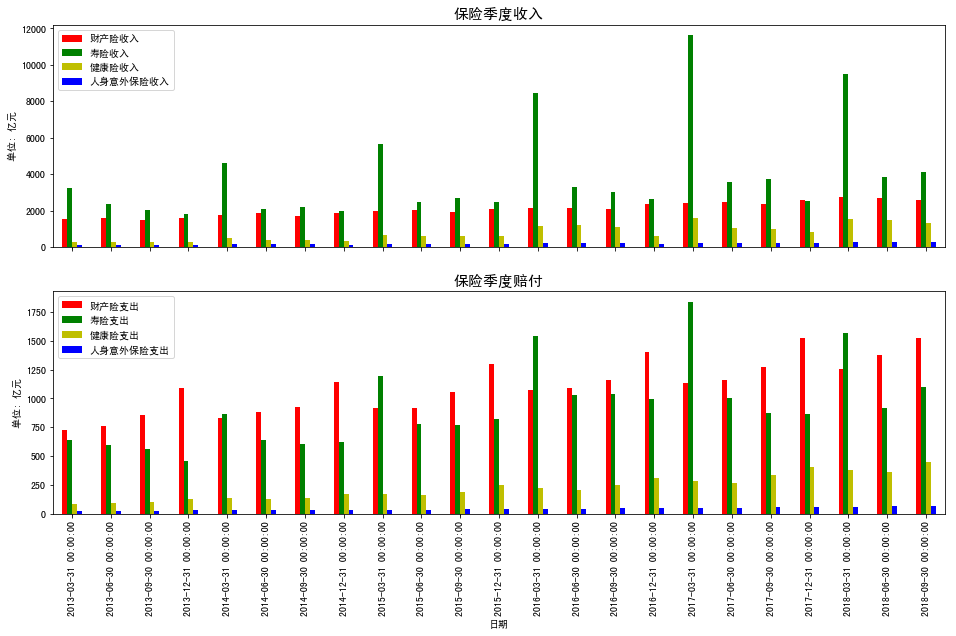

In [15]:
# 画两个柱状图，对应收入和赔付支出的历史数据

my_colors = ['r', 'g', 'y', 'b']  # 对四种险种定义4个颜色对应

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True,
                         figsize=(16, 12))  # 画两个柱状图，分别对应收入和赔付支出

df_quarter.iloc[:, [1, 3, 4, 5]].plot.bar(
    figsize=(16, 9), ax=axes[0], color=my_colors)  # 四个险种的收入季度柱状图
df_quarter.iloc[:, [7, 9, 10, 11]].plot.bar(
    figsize=(16, 9), ax=axes[1], color=my_colors)  # 四个险种的赔付支出季度柱状图

axes[0].set_title("保险季度收入", fontsize=15)  # 定义柱状图 title
axes[1].set_title("保险季度赔付", fontsize=15)

axes[1].set_xlabel("日期")  # 定义柱状图的 x，y 轴 label
axes[1].set_ylabel("单位: 亿元")
axes[0].set_ylabel("单位: 亿元")

patches, labels = axes[0].get_legend_handles_labels()  # 这两行代码是为了调整图中示例标签的位置
axes[0].legend(patches, labels, loc=2)

从2013年至今的保险各险种季度收入和赔付柱状图我们可以看到：

1.从保费收入来看，整体体量寿险和财险收入要明显高于健康险和人身意外险。其中寿险在每年的第一季度总能一骑绝尘，峰值甚至能超万亿大关。和所有其他险种拉开巨大的差距。究其原因其实还是前面提过的年金险引起的。由于年金险强大的吸金效益，每年年末新年伊始各家保险公司都会倾尽所能卖自己的“开门红”产品，这些“开门红”基本都是年金险。这就造成了第一季度巨量的保费收入。

2.从保费赔付支出来看，首先我们可以发现Y轴单位差了整整一个量级，说明保险业整体盈利能力还是非常巨大的。其次，虽然峰值依然是寿险的，但是平均来看显然财险总支出会更大些，这也符合我们前面饼图显示的各险种赔付比例。至于为什么第一季度寿险赔的也特别多呢？当然是因为年金险这个季度签得多，由于年金险赔付都是按年支出，自然同样的季节赔的也就多了。

有意思的是财险总是第四季度赔付最多，应该是和大家年前清账，以便进行全年盈亏统计不无关系。

3.两张柱状图中，健康险和意外险长度都非常短，说明这两个险种体量和另外两个比起来还有相当的差距，这也符合我们前面饼图的分析结果。

接下来我们在再来看看月同比增长率的折线图

Text(0.5,1,'寿险/健康险月同比增长率')

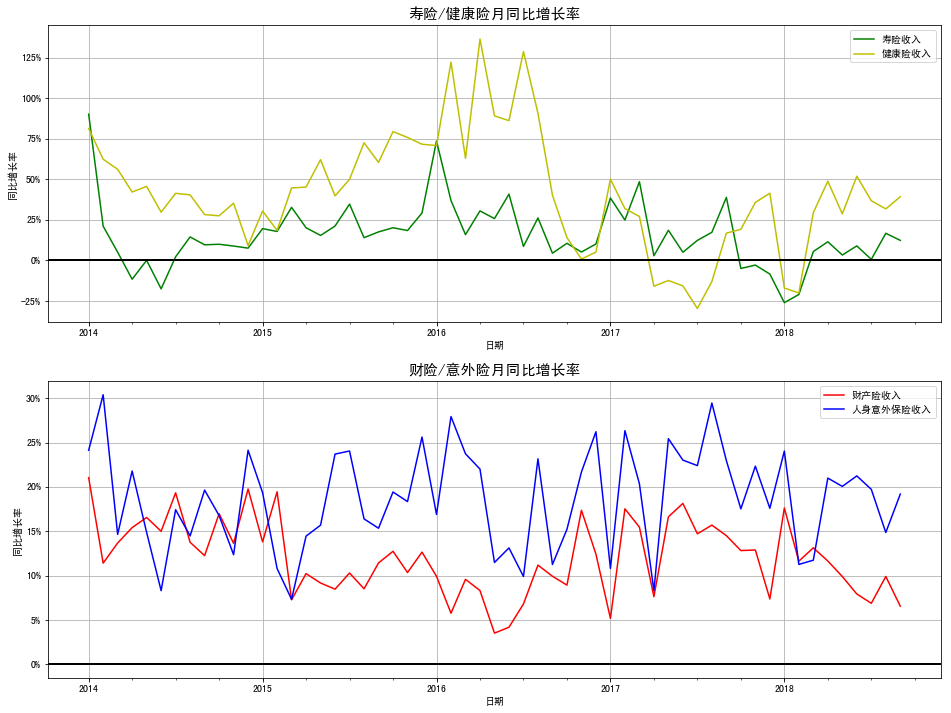

In [15]:
# 画月同比增长率的折线图
from matplotlib.ticker import FuncFormatter

# 计算月同比增长率，取值时去掉最初作为 base 数据的12个月
df_month_rate = df_month.pct_change(periods=12).iloc[12:, :]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

df_month_rate.iloc[:, [3, 4]].plot(
    color=['g', 'y'], ax=axes[0], figsize=(16, 12), grid=True)  # 为避免凌乱，将4个险种两两分开显示
df_month_rate.iloc[:, [1, 5]].plot(
    color=['r', 'b'], ax=axes[1], figsize=(16, 12), grid=True)


def to_percent(temp, position):  # 定义一个可以在 y 轴将小数显示成百分数的函数
    return '%.f' % (100*temp) + '%'


for i in range(0, 2):  # 定义 x，y 轴 label 和格式，多画一条 y=0 的基准线
    axes[i].yaxis.set_major_formatter(FuncFormatter(to_percent))
    axes[i].set_ylabel("同比增长率")
    axes[i].set_xlabel("日期")
    axes[i].axhline(y=0, color='black', lw=2)

axes[1].set_title("财险/意外险月同比增长率", fontsize=15)  # 定义图像 title
axes[0].set_title("寿险/健康险月同比增长率", fontsize=15)

从分组后的月同比增长率我们可以看到：

1.根据Y轴的数值，总得来说各险种收入和赔付都处在高速的增长中，说明我国保险业近几年发展速度迅猛。

2.从各险种而言，我们可以看到健康险收入的同比增长率在2017年以前明显高于其他险种，增幅最高可以超过125%。当时超高的增长率主要是由于16年底前市场有很多带理财属性的短期/定期健康险（很多都是直接银行当有保险功能的理财产品代卖），受到当时消费者的热捧。

然而我们可以看到健康险的同比增长率自16年底开始出现急跌，17年中旬和18年开年甚至录得了负增长。其背后的原因是因为自16年中旬开始，相关监管机构和高层就开始放出“保险信保”信号，要求行业回归本源，大力发展保障型产品，而不是吸收资金只求规模，避免造成潜在金融系统风险。随之对应的是先后出台多项红头文件和措施，杜绝了健康险同年金险一样朝偏理财产品的转变。

但是就算如此，其实健康险同比增长率也并非一蹶不振，17年后期及18年中期依旧能够录得超过25%甚至50%的高速的增长率，说明了健康险在更注重保障以后仍然有广阔的发展空间，这是由于75,80后的人们开始保险意识的逐步觉醒，很多人开始自发的去了解保险，主动购买保险。这种主动行为目标都是以重疾险，医疗险等健康险为主体的。

3.相对于健康险的超高增长，寿险的增长率略低，且自16初后似乎就开始进入下降通道。主要原因还是“保险信保”的政策改变引起的。特别是17年10月份开始实行的著名的134号文件，对年金险很多快速返还，高额利率等有潜在风险的行业做法做了更严格的规定和限制，从而使年金险作为理财产品的吸引力大幅下降。

3.相对于前两个险种而言，财险和人身意外险的同比增长率虽然没有超高速的增长率，但是胜在稳定，财险的增长范围在5% - 20%之间波动，健康险则更高，增长率保持在10% - 30%的区间，财险相对增长率较低时因为其是较为成熟的市场，没有太多增长空间可以想象。意外险则是因为体量过小，本身保单单价也相当便宜，随手就能买，预示着更大的发展空间。

#### 未来状态预测

由于保险数据非常规整的季度性，很适合用prophet工具进行时间序列的分析和预测。我们会对各保险在未来三年内进行保费收入，月同比增长率以及各险种在总保险收入中的占比进行预测。

In [16]:
# 如果没有，需要先安装 fbprophet
#!conda install -c conda-forge --yes fbprophet
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

以下是各保险在未来三年内保费收入预测

In [17]:
# 定义一个调用prophet并画出相应预测图的函数
def prophet_image(df, periods, ax):  # 传入 DataFrame，预测时长和子图序列信息

    df = df.reset_index()  # 重置索引
    df.columns = ['ds', 'y']
    m = Prophet()  # 创建加法模型
    m.fit(df)  # 训练

    future = m.make_future_dataframe(periods=periods, freq='M')  # 生成预测序列
    forecast = m.predict(future)  # 预测
    fig = m.plot(forecast, ax=ax)  # 绘图

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5,18.8,'人身意外险保费未来三年预测')

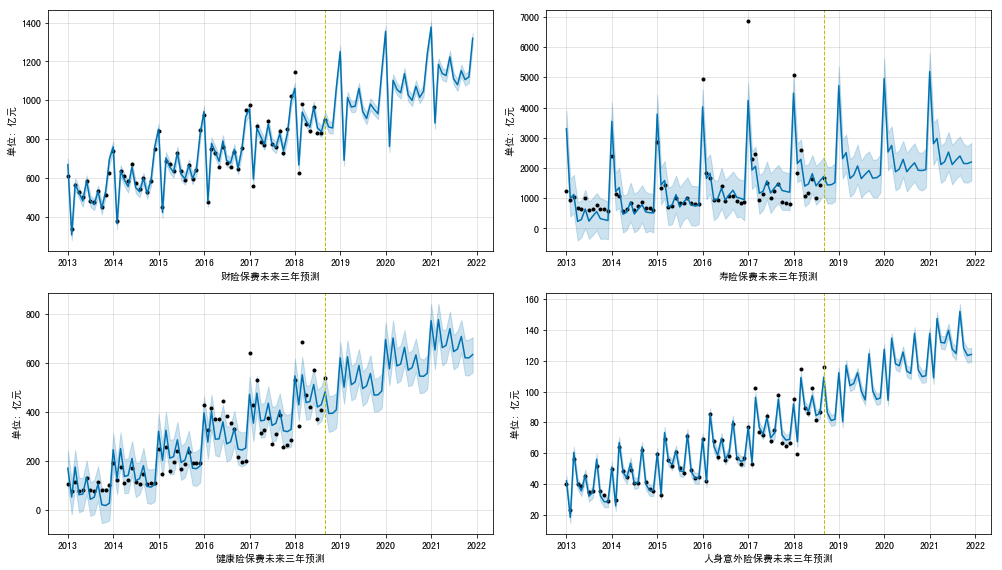

In [18]:
# 绘制4中保险月收入未来三年的预测图
# 绘制一个 2X2 的图，分别对应四个险种
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

prophet_image(df_month.iloc[:, 1], 39, axes[0, 0])  # 调用上面定义的函数进行未来3年的保费数据预测
prophet_image(df_month.iloc[:, 3], 39, axes[0, 1])
prophet_image(df_month.iloc[:, 4], 39, axes[1, 0])
prophet_image(df_month.iloc[:, 5], 39, axes[1, 1])

for i in range(0, 2):  # 定义个子图 y 轴 label，加画一条 x 轴基准线已区分历史值和预测值
    for j in range(0, 2):
        axes[i, j].set_ylabel("单位: 亿元")
        axes[i, j].axvline(x='2018-09-01', ls="--", color="y", lw=1)

axes[0, 0].set_xlabel("财险保费未来三年预测")  # 定义各子图的 x 轴 label
axes[0, 1].set_xlabel("寿险保费未来三年预测")
axes[1, 0].set_xlabel("健康险保费未来三年预测")
axes[1, 1].set_xlabel("人身意外险保费未来三年预测")

从四种险种的未来三年保费收入预测图中我们可以看到:

1.各个险种的保费收入依旧能够稳步增长，说明整个行业总体增长的基石依然存在，行业还是很有发展前景的。

2.从斜率上我们也可以看出来，寿险保费预测的斜率明显低于其他三个险种，显示出寿险由于受规模和政策的影响，发展趋缓。

3.每个图中折线周边的蓝色阴影部分标志着此点对应日期所预测数值的离散范围。财险和意外险阴影很小，说明这两个险种过往的运营数据规律性明显，所以预测值离散很小。而寿险和健康险由于受政策和民众对保险/理财等理念转变的影响较大，过往数据规律性较差，所以预测值的离散程度也就较高。

以下是各保险在未来三年内月同比增长率预测

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5,18.8,'人身意外险月同比增长率保费未来三年预测')

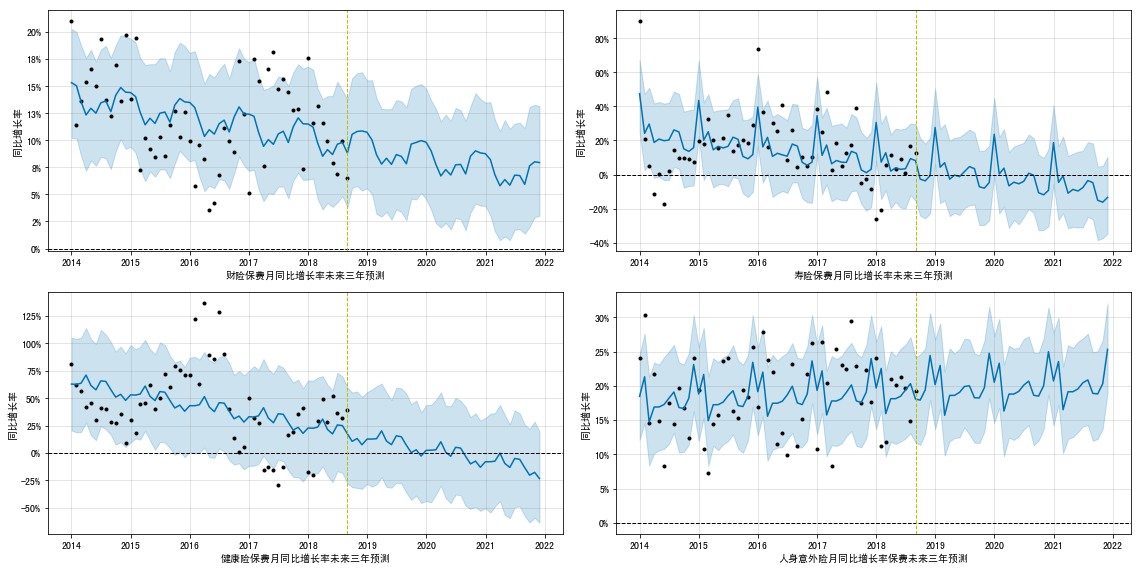

In [19]:
# 绘制一个 2X2 的图，分别对应四个险种
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

# 调用上面定义的函数进行未来3年的月同比增长率预测
prophet_image(df_month_rate.iloc[:, 1], 39, axes[0, 0])
prophet_image(df_month_rate.iloc[:, 3], 39, axes[0, 1])
prophet_image(df_month_rate.iloc[:, 4], 39, axes[1, 0])
prophet_image(df_month_rate.iloc[:, 5], 39, axes[1, 1])

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].yaxis.set_major_formatter(
            FuncFormatter(to_percent))  # 对各子图设定 y 轴百分比显示
        axes[i, j].set_ylabel("同比增长率")  # 对各子图定义 y 轴label
        axes[i, j].axhline(y=0, ls="--", color="black",
                           lw=1)  # 对各子图加画一条 y=0 基准线
        axes[i, j].axvline(x='2018-09-01', ls="--", color="y",
                           lw=1)  # 对各子图加画一条 x 轴基准线已区分历史值和预测值


axes[0, 0].set_xlabel("财险保费月同比增长率未来三年预测")  # 定义各子图的 x 轴 label
axes[0, 1].set_xlabel("寿险保费月同比增长率未来三年预测")
axes[1, 0].set_xlabel("健康险保费月同比增长率未来三年预测")
axes[1, 1].set_xlabel("人身意外险月同比增长率保费未来三年预测")

从四种险种的未来三年保费月同比增长率预测图中我们可以看到:


1.财险，寿险和健康险增长率都是下降趋势，说明整体而言，中国保险业的发展速度会趋缓，以后超过50%甚至100%的增长速度可能较难再现。

2.从各险种上来说，增长率下降或者上升的原因各不相同。

   a.对财险来说，其实在三年之内其增长率依旧是正值，只是趋势放缓，从15%左右降到8%左右。财险产业发展已经比较成熟，我国不管是楼市，基建，车市等都趋于饱和，所以对应的财险短期看不到新增长点来拉动财险继续保持高速的发展，增长率的下降是可以理解的。
 
   b.寿险增长率下降甚至很快就会进入负增长阶段，主要还是受作为保费收入的大头---年金险吸金魔力不再导致的。当前作为社会主力的75,80后对理财的理念和渠道同父辈相比拥有更多的自己的理解和考量。在“保险姓保”的政策限制了快返还，高利率账户的大背景下，年金险已经开始慢慢失去青壮年的青睐。
 
   c.健康险虽然趋势也是下降的，但是健康险历史过往增长率离散巨大，预测效果被最近数值影响很大，如果引入更长时间的历史数据，趋势可能会有所不同。短期内健康险也需要摆脱“保险姓保”的政策影响，但是长期来看国民保险意识觉醒以后的主要目标就是健康险，所以我认为市场前景仍然值得期待。
 
   d.人身意外险的同比增长率预测是唯一保持上升的，意外险由于体量较低，保单单价低，发展空间巨大。


我们最后再看下各险种在未来三年对于总保费的占比情况。

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


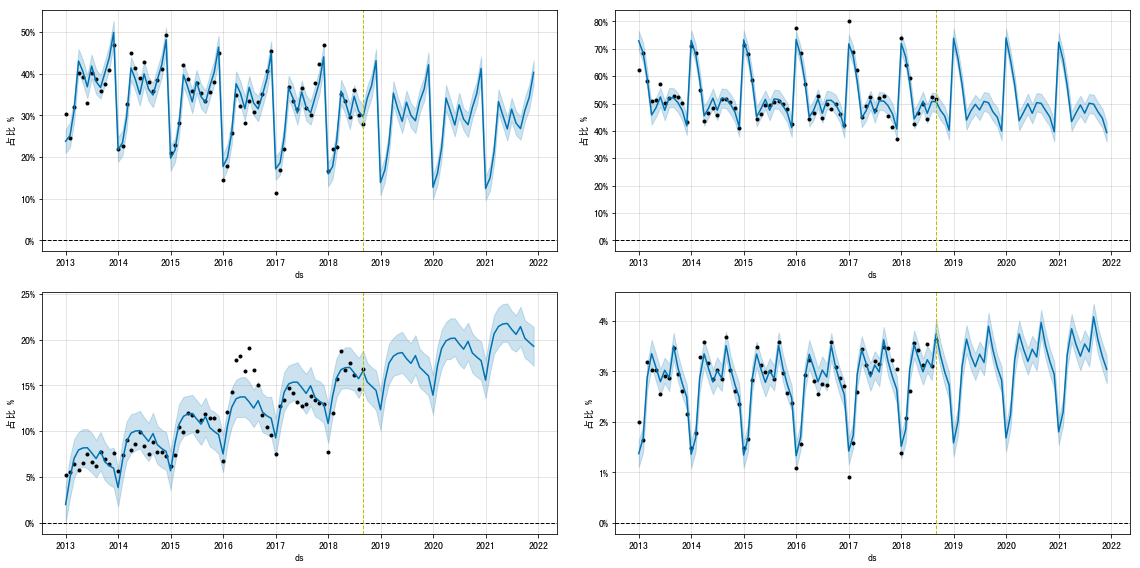

In [20]:
# 绘制一个 2X2 的图，分别对应四个险种
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

prophet_image(df_month.iloc[:, 1]/df_month.iloc[:, 0],
              39, axes[0, 0])  # 将单个险种保费除以总保费的数值带入函数中进行预测
prophet_image(df_month.iloc[:, 3]/df_month.iloc[:, 0], 39, axes[0, 1])
prophet_image(df_month.iloc[:, 4]/df_month.iloc[:, 0], 39, axes[1, 0])
prophet_image(df_month.iloc[:, 5]/df_month.iloc[:, 0], 39, axes[1, 1])

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].yaxis.set_major_formatter(
            FuncFormatter(to_percent))  # 对各子图设定 y 轴百分比显示
        axes[i, j].set_ylabel("占比 %")  # 对各子图定义 y 轴 label
        axes[i, j].axhline(y=0, ls="--", color="black",
                           lw=1)  # 对各子图加画一条 y=0 基准线
        axes[i, j].axvline(x='2018-09-01', ls="--", color="y",
                           lw=1)  # 对各子图加画一条 x 轴基准线已区分历史值和预测值

从各险种占总保费收入的比重预测图中我们可以看到，财险和寿险的份额会逐渐缩小，健康险和意外险的份额会逐渐扩大。这也预示着未来市场发展的重点和方向的转变。

#### 数据分析总结

根据对保险业近五年基础数据的分析，我们可以知道，

首先保险业务收入支出巨大，巨大的保费收入最终会通过各种投资渠道流入到整个金融市场中去，在整个金融体系中占据的不可忽视的作用和地位。

对具体险种而言，财险市场总体稳定独立，发展良好。而在人寿险市场，在过去及可预见未来的时间内，寿险（年金险）市场仍将是每个保险公司的必争之地，体量巨大，利润丰厚。但是随着政策的扶持，国民保险意识的觉醒，健康险和人身意外险已经开始奋起直追，他们将是未来新兴的增长点。

### 项目作业总结

本次我的作业选取了这两年我个人比较感兴趣，自己平时比较关注的保险业进行了简单的分析，从选题，数据抓取，建模分析独立完成，历时一周，花了大量的时间。虽然这份报告对于真正业内人士来说只能算是皮毛，但是也给了我一个很好了解，体验数据挖掘/数据分析这方面工作的机会。最大的感受是最重要的是好的，足够完备的数据，有了好的数据，后面的分析建模很多时候就是水到渠成的事情了。

感谢实验楼导师和助教在楼+教学期间对我的指导和帮助，希望以后能够更多的机会学以致用。

---

#### 评阅意见反馈

<div style="color: #666; font-size: 10px;">
stenphen 提交的《中国保险业过去五年基础数据分析》项目挑战报告内容丰富详实，逻辑连贯，为读者传达了清晰的分析过程和结论。
<br><br>
报告从数据采集开始，对和讯保险页面提供的行业基础数据进行了采集。由于数据清洗过程中发现缺失数据，作者进行了填充。首先，这里对数据是否填充的判断是正确的，同时选择从可信数据源人工填充的方法十分合理。不过，在此建议后续寻找更为合适的数据源，以便于采集更多数据或二次利用数据时减轻工作量。从第三方采集数据时，配合与可信数据源之间抽样验证以确保数据的可靠性。
<br><br>
数据分析阶段，关于保险收入和支出的饼图选择合理，能够直观传达数据重要含义。后续保险季度收入和赔付柱状图虽然能够传达现有结论，但可以考虑使用堆叠柱状体更清晰地表达收入和支出的比例以及保费结余信息。示例如下：
<br><br>
建模预测阶段，选择使用时间序列建模方法是合理的。不过，像「健康险保费未来三年预测」等建模时选择乘法模型应该比加法模型更能准确反映数据的数值未来变化。
<br><br>
增长率未来三年预测建模时，由于时间序列呈现出较强的随机波动，模型的值预测或许不会非常准确。当然，这里使用 fbprophet 绘图用来反映增长或减少趋势是可以的。对于这类随机性较强的序列，目前没有太好的方法进行准确值预测。
<br><br>
报告在各分析阶段都进行了讨论，并在报告最后进行整体结论总结，这一点做得非常出色。数据分析的过程很重要，实际上阐述结论和讲好一个故事更加重要。
<br><br>
总之，通过该报告可以判定学员已经达到我们课程预设的培养目标，希望 stenphen 后续再通过书籍等拓展更多相关的数据分析和挖掘知识，并结合自己的兴趣及专业特长在数据分析的道路上越走越好。
</div>

<br><br><br>
<div style="color: #666; font-size: 10px; text-align: right;">楼+ 数据分析和挖掘课程组</div>
<div style="color: #666; font-size: 10px; text-align: right;">2018 年 12 月 17 日</div>

---